In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train_dir = "/content/drive/MyDrive/Workshop5_AI/FruitinAmazon/train"
test_dir = "/content/drive/MyDrive/Workshop5_AI/FruitinAmazon/test"

In [5]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['guarana', 'graviola', 'acai', 'cupuacu', 'tucuma', 'pupunha']


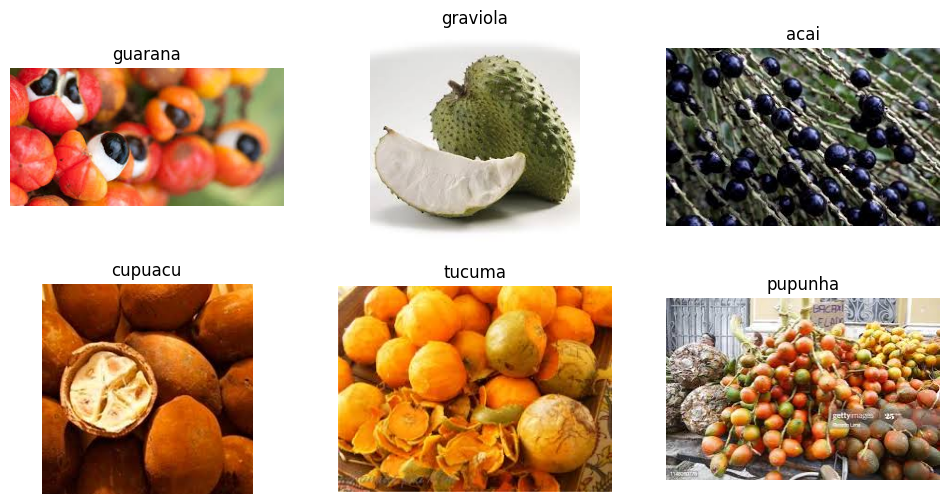

In [6]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [7]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)  # Try opening the image
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [8]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [11]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [12]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.1904 - loss: 2.2249

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 694ms/step - accuracy: 0.1879 - loss: 2.2723 - val_accuracy: 0.8333 - val_loss: 1.1333
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.1853 - loss: 1.8386 - val_accuracy: 0.0000e+00 - val_loss: 1.7819
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 536ms/step - accuracy: 0.3338 - loss: 1.6873 - val_accuracy: 0.0000e+00 - val_loss: 1.8785
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.1793 - loss: 1.6343 - val_accuracy: 0.0000e+00 - val_loss: 1.9184
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.3702 - loss: 1.5101 - val_accuracy: 0.3333 - val_loss: 1.7069
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.5425 - loss: 1.4167 - val_accuracy: 0.1667 - val_loss: 1.7707
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - accuracy: 0.5000 - loss: 1.2407 - val_accuracy: 0.4444 - val_loss: 1.5451
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.6302 - loss: 1.0921 - val_accuracy: 0.5000 - v

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 842ms/step - accuracy: 0.8485 - loss: 0.6031 - val_accuracy: 0.8889 - val_loss: 0.8000
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 545ms/step - accuracy: 0.9301 - loss: 0.4003 - val_accuracy: 0.8333 - val_loss: 0.9476
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.9332 - loss: 0.3115 - val_accuracy: 0.7778 - val_loss: 0.7349
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.9813 - loss: 0.1743 - val_accuracy: 0.8333 - val_loss: 0.6318
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 545ms/step - accuracy: 0.9705 - loss: 0.1615 - val_accuracy: 0.8889 - val_loss: 0.4253
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 690ms/step - accuracy: 1.0000 - loss: 0.1146 - val_accuracy: 0.8333 - val_loss: 0.5765
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.9891 - loss: 0.0582 - val_accuracy: 0.7778 - val_loss: 0.8537
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 536ms/step - accuracy: 1.0000 - loss: 0.0506 - val_accuracy: 0.8889 - val_lo

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step - accuracy: 1.0000 - loss: 0.0232 - val_accuracy: 0.9444 - val_loss: 0.4446
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 547ms/step - accuracy: 1.0000 - loss: 0.0240 - val_accuracy: 0.8889 - val_loss: 0.3478
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 474ms/step - accuracy: 1.0000 - loss: 0.0142 - val_accuracy: 0.9444 - val_loss: 0.4080
Epoch 23/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 514ms/step - accuracy: 1.0000 - loss: 0.0101 - val_accuracy: 0.8889 - val_loss: 0.7530
Epoch 24/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 789ms/step - accuracy: 0.9627 - loss: 0.0584 - val_accuracy: 0.8889 - val_loss: 0.4801
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 1.0000 - loss: 0.0071 - val_accuracy: 0.7778 - val_loss: 0.5452
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.8333 - val_loss: 0.5479
Epoch 27/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 0.8889 - val_lo

In [15]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.5667 - loss: 1.3295
Test Accuracy: 56.67%


In [16]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
              precision    recall  f1-score   support

     guarana       0.75      0.60      0.67         5
    graviola       0.33      0.40      0.36         5
        acai       0.67      0.80      0.73         5
     cupuacu       0.75      0.60      0.67         5
      tucuma       0.71      1.00      0.83         5
     pupunha       0.00      0.00      0.00         5

    accuracy                           0.57        30
   macro avg       0.54      0.57      0.54        30
weighted avg       0.54      0.57      0.54        30



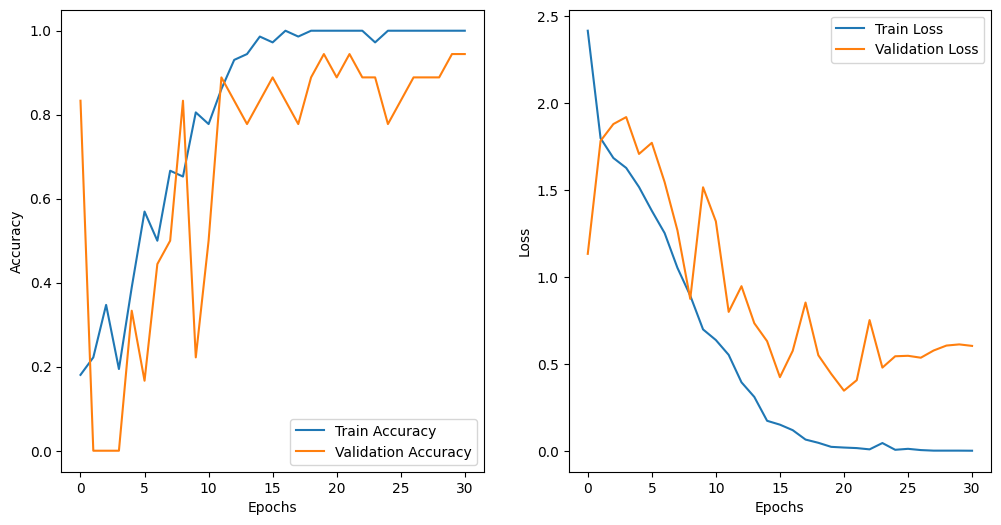

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()